In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [19]:
forecast_demand_file_path = '../data/forecastdemand_nsw.csv'
actual_demand_file_path = '../data/totaldemand_nsw.csv'
temperature_file_path = '../data/temperature_nsw.csv'
forecast_demand = pd.read_csv(forecast_demand_file_path)
actual_demand = pd.read_csv(actual_demand_file_path)
temperature = pd.read_csv(temperature_file_path)

Exports_file_path = '../data/Exports - quarterly 2010-2023.csv'
GDP_file_path = '../data/GDP - quarterly 2010-2023.csv'
Interest_file_path = '../data/Interest rate - daily 2011-2023.csv'
SolarInstall_file_path = '../data/Solar installation number - monthly 2007-2023.csv'
SolarOutput_file_path = '../data/Solar outputs - monthly 2015-2023.csv'
Unemployment_file_path = '../data/Unemployment rate - monthly 2010-2023.csv'
Wholesale_file_path = '../data/Wholesale electricity price - half hourly 2014-2023.csv'
cpi_file_path = '../data/inflation-data.xls'
comm_file_path = '../data/Commodity prices index - monthly 2010-2023.csv'
rainfall_file_path = '../data/Rainfall - daily 2010-2023.csv'
weather_file_path = '../data/Weather - daily 2022-2023.csv'

cpi = pd.read_excel(cpi_file_path)
Exports = pd.read_csv(Exports_file_path)
GDP = pd.read_csv(GDP_file_path)
Interest = pd.read_csv(Interest_file_path)
SolarInstall = pd.read_csv(SolarInstall_file_path)
SolarOutput = pd.read_csv(SolarOutput_file_path)
Unemployment = pd.read_csv(Unemployment_file_path)
Wholesale = pd.read_csv(Wholesale_file_path)
Comm = pd.read_csv(comm_file_path)
Rainfall = pd.read_csv(rainfall_file_path)
Weather = pd.read_csv(weather_file_path)

In [20]:
path = '../data/nswdemand2022onwards'
all_files = glob.glob(os.path.join(path, "*.csv"))

total_demand_2022onwards = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [21]:
lag_value = -6
test_date = '2020-11-30'

In [22]:
temperature.loc[temperature['TEMPERATURE'] <= -5, 'TEMPERATURE'] = np.nan
df = pd.DataFrame({'Date Time': actual_demand['DATETIME'], 'Total Demand': actual_demand['TOTALDEMAND']})
df = pd.merge(df,temperature,left_on=['Date Time'], right_on=['DATETIME'], how = 'left')
df=df.drop(columns=['DATETIME', 'LOCATION'])
df['TEMPERATURE'] = df['TEMPERATURE'].interpolate(method='linear')
df['Date Time'] = pd.to_datetime(df['Date Time'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
forecast_demand['DATETIME'] = pd.to_datetime(forecast_demand['DATETIME'])
actual_demand['DATETIME'] = pd.to_datetime(actual_demand['DATETIME'])
fore = forecast_demand.set_index('DATETIME').resample('1H').mean()[['FORECASTDEMAND']]
actu = actual_demand.set_index('DATETIME').resample('1H').mean()[['TOTALDEMAND']]
merged_df = fore.join(actu).dropna()
merged_df['DIFF'] = merged_df.eval('TOTALDEMAND - FORECASTDEMAND')
merged_df['Demand_Previous'] = merged_df['TOTALDEMAND'].shift(periods=(-24))
merged_df['Demand_Lagged'] = merged_df['TOTALDEMAND'].shift(periods=(lag_value))
merged_df['Demand_Rolling'] = merged_df['Demand_Lagged'].rolling(window=720).mean()

temperature['DATETIME'] = pd.to_datetime(temperature['DATETIME'])
temp = temperature.set_index('DATETIME').resample('1H').mean()
temp['TEMPERATURE_lagged'] = temp['TEMPERATURE'].shift(periods=lag_value)
data = merged_df.merge(temp, left_index=True, right_index=True, how='inner')
data = data.drop(['LOCATION','TEMPERATURE', 'FORECASTDEMAND', 'DIFF'], axis=1)
df = data.dropna()


column_rename_mapping = {
    'G1 CONSUMER PRICE INFLATION': 'DATETIME',
    'Unnamed: 1': 'cpi'
}
cpi = cpi.rename(columns=column_rename_mapping)[10:].dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
cpi.index = pd.to_datetime(cpi.index, format='%b-%Y')
cpi = cpi[(cpi.index >= min_date) & (cpi.index <= max_date)]
cpi = cpi.reindex(date_range).fillna(method='ffill')
cpi['CPI_lagged'] = cpi['cpi'].shift(periods=lag_value)
cpi = cpi[['CPI_lagged']]
df = pd.concat([df, cpi], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Exports of goods and services': 'Exports'
}
Exports = Exports.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Exports.index = pd.to_datetime(Exports.index, format='%b-%Y')
Exports = Exports[(Exports.index >= min_date) & (Exports.index <= max_date)]
Exports = Exports.reindex(date_range).fillna(method='ffill')
Exports['Exports_lagged'] = Exports['Exports'].shift(periods=lag_value)
Exports = Exports[['Exports_lagged']]
df = pd.concat([df, Exports], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Real GDP': 'GDP'
}
GDP = GDP.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
GDP.index = pd.to_datetime(GDP.index, format='%b-%Y')
GDP = GDP[(GDP.index >= min_date) & (GDP.index <= max_date)]
GDP = GDP.reindex(date_range).fillna(method='ffill')
GDP['GDP_lagged'] = GDP['GDP'].shift(periods=lag_value)
GDP = GDP[['GDP_lagged']]
df = pd.concat([df, GDP], axis=1).dropna()

column_rename_mapping = {
    'Date': 'DATETIME',
    'Cash Rate Target': 'Interest'
}
Interest = Interest.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Interest.index = pd.to_datetime(Interest.index)
Interest = Interest[(Interest.index >= min_date) & (Interest.index <= max_date)]
Interest = Interest.reindex(date_range).fillna(method='ffill')
Interest['Interest_lagged'] = Interest['Interest'].shift(periods=lag_value)
Interest = Interest[['Interest_lagged']]
df = pd.concat([df, Interest], axis=1).dropna()

column_rename_mapping = {
    "'Month'": 'DATETIME',
    'Cumulative Residential': 'Residential',
    'Cumulative Commercial': 'Commercial'
}
SolarInstall = SolarInstall.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarInstall.index = pd.to_datetime(SolarInstall.index)
SolarInstall = SolarInstall[(SolarInstall.index >= min_date) & (SolarInstall.index <= max_date)]
SolarInstall = SolarInstall.reindex(date_range).fillna(method='ffill')
SolarInstall['Residential_lagged'] = SolarInstall['Residential'].shift(periods=lag_value)
SolarInstall['Commercial_lagged'] = SolarInstall['Commercial'].shift(periods=lag_value)
SolarInstall = SolarInstall[['Residential_lagged','Commercial_lagged']]
df = pd.concat([df, SolarInstall], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Output NSW': 'SolarOutput'
}
SolarOutput = SolarOutput.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
SolarOutput.index = pd.to_datetime(SolarOutput.index)
SolarOutput = SolarOutput[(SolarOutput.index >= min_date) & (SolarOutput.index <= max_date)]
SolarOutput = SolarOutput.reindex(date_range).fillna(method='ffill')
SolarOutput['SolarOutput_lagged'] = SolarOutput['SolarOutput'].shift(periods=lag_value)
SolarOutput = SolarOutput[['SolarOutput_lagged']]
df = pd.concat([df, SolarOutput], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Unemployment rate': 'Unemployment'
}
Unemployment = Unemployment.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Unemployment.index = pd.to_datetime(Unemployment.index, format='%b-%Y')
Unemployment = Unemployment[(Unemployment.index >= min_date) & (Unemployment.index <= max_date)]
Unemployment = Unemployment.reindex(date_range).fillna(method='ffill')
Unemployment['Unemployment_lagged'] = Unemployment['Unemployment'].shift(periods=lag_value)
Unemployment = Unemployment[['Unemployment_lagged']]
df = pd.concat([df, Unemployment], axis=1).dropna()

column_rename_mapping = {
    "SETTLEMENTDATE": 'DATETIME',
    'RRP': 'Price'
}
Wholesale = Wholesale.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Wholesale.index = pd.to_datetime(Wholesale.index, format='%Y/%m/%d %H:%M:%S')
Wholesale = Wholesale[(Wholesale.index >= min_date) & (Wholesale.index <= max_date)]
Wholesale = Wholesale.reindex(date_range).fillna(method='ffill')
Wholesale['Price_lagged'] = Wholesale['Price'].shift(periods=lag_value)
Wholesale = Wholesale[['Price_lagged']]
df = pd.concat([df, Wholesale], axis=1).dropna()

column_rename_mapping = {
    "Date": 'DATETIME',
    'Commodity prices ': 'CommPrice'
}
Comm = Comm.rename(columns=column_rename_mapping).dropna().set_index('DATETIME')
min_date, max_date = data.index.min(), data.index.max()
date_range = pd.date_range(start=min_date, end=max_date,freq='1H')
Comm.index = pd.to_datetime(Comm.index, format='%b-%Y')
Comm = Comm[(Comm.index >= min_date) & (Comm.index <= max_date)]
Comm = Comm.reindex(date_range).fillna(method='ffill')
Comm['CommPrice_lagged'] = Comm['CommPrice'].shift(periods=lag_value)
Comm = Comm[['CommPrice_lagged']]
df = pd.concat([df, Comm], axis=1).dropna()
df['HourOfDay'] = df.index.hour
# day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df.index.dayofweek#.map(day_mapping)
df['DayOfYear'] = df.index.dayofyear
df['IsWeekend'] = np.where((df['DayOfWeek'] == 5) | (df['DayOfWeek'] == 6), 1, 0)
# df = pd.get_dummies(df, columns=['HourOfDay'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Day')
# df = pd.get_dummies(df, columns=['DayOfYear'], prefix='Year')

In [ ]:
To_Z_Score = ['TOTALDEMAND',
 'Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged']

In [25]:
list(df.columns)

['TOTALDEMAND',
 'Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'HourOfDay',
 'DayOfWeek',
 'DayOfYear',
 'IsWeekend']

In [ ]:
(forecast_demand.set_index('DATETIME').resample('1H').mean()['FORECASTDEMAND'] - actual_demand.set_index('DATETIME').resample('1H').mean()['TOTALDEMAND']).plot()

In [ ]:
mse = mean_squared_error(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
r2 = r2_score(merged_df['FORECASTDEMAND'], merged_df['TOTALDEMAND'])
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:], alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Forecast Values")
plt.title("Actual vs. Forecast Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], [min(merged_df['FORECASTDEMAND']), max(merged_df['FORECASTDEMAND'])], color='red', linestyle='--')

plt.show()

In [ ]:
# Evaluate the aemo model's performance
mse = mean_squared_error(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])
r2 = r2_score(merged_df['FORECASTDEMAND'].loc[test_date:], merged_df['TOTALDEMAND'].loc[test_date:])

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
target_column = 'TOTALDEMAND'
feature_columns = [col for col in data.columns if col != target_column]
data = data.dropna()
# Split the dataset into training and testing sets
train_data = data.loc[data.index <= test_date]
test_data = data.loc[data.index > test_date]

# Define training and testing features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Create an instance of the LinearRegression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, you can inspect the model coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [ ]:
target_column = 'TOTALDEMAND'
feature_columns = [col for col in df.columns if col != target_column]
df = df.dropna()
# Split the dataset into training and testing sets
train_data = df.loc[df.index <= test_date]
test_data = df.loc[df.index > test_date]

# Define training and testing features and target
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

# Create an instance of the LinearRegression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, you can inspect the model coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [17]:
def run_xdg_model(df, target, norm_columns, exclude_features=[], n_estimators=1500):
    feature_columns = [col for col in data.columns if col != target_column]
    feature_subset = [col for col in feature_columns if col != exclude_features]

    keys = list(df.keys())
    norm_columns = [x for x in keys if x in norm_column]

    df = df.dropna()

    train_data = df.loc[df.index <= test_date].copy()
    test_data = df.loc[df.index > test_date].copy()

    scaler = StandardScaler()
    train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
    test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

    X_train, y_train = train_data[feature_subset], train_data[target_column]
    X_test, y_test = test_data[feature_subset], test_data[target_column]

    xgb_model = XGBRegressor(n_estimators=n_estimators, random_state=42)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)

    mse, r2 = mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    plt.show()

In [ ]:
run_xdg_model(data, 'target_column', To_Z_Score)

In [ ]:
Weather

In [ ]:
Rainfall

In [ ]:
run_xdg_model(df, 'TOTALDEMAND', To_Z_Score, n_estimators=5000)

In [ ]:
not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear','IsWeekend', 'TOTALDEMAND','Demand_Lagged','Demand_Previous','Demand_Rolling']
keys = list(df.keys())
norm_columns = [x for x in keys if x not in not_norm_column]

In [ ]:
# Define target and feature columns
target_column = 'TOTALDEMAND'
keys = list(df.keys())
feature_columns = [x for x in keys if x != target_column]

not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear','IsWeekend','TOTALDEMAND','Demand_Lagged','Demand_Previous','Demand_Rolling']
keys = list(df.keys())
norm_columns = [x for x in keys if x not in not_norm_column]

# feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TEMPERATURE_lagged','CPI_lagged']
df = df.dropna()

# Split the data into training and testing sets
train_data = df.loc[df.index <= test_date].copy()
test_data = df.loc[df.index > test_date].copy()

scaler = StandardScaler()
train_data.loc[:, norm_columns] = scaler.fit_transform(train_data.loc[:, norm_columns])
test_data.loc[:, norm_columns] = scaler.transform(test_data.loc[:, norm_columns])

# Define training and testing features and target
X_train = train_data.loc[:, feature_columns]
y_train = train_data.loc[:, target_column]

X_test = test_data.loc[:, feature_columns]
y_test = test_data.loc[:, target_column]

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=2000, random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

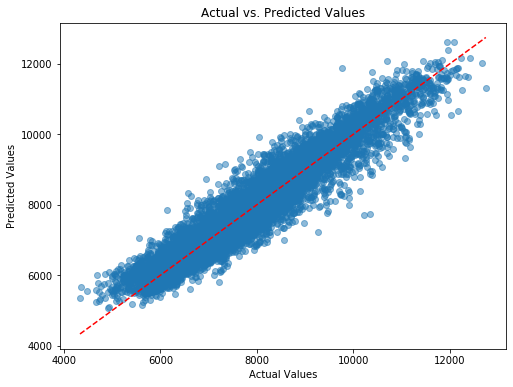

In [46]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

In [47]:
# # Initialize variables to keep track of the weakest feature column and its R² value
# weakest_feature = None
# weakest_r2 = float('inf')

# # Iterate through all possible feature columns to exclude one at a time
# for column_to_exclude in feature_columns:
#     # Create a list of feature columns excluding the current one
#     feature_subset = [col for col in feature_columns if col != column_to_exclude]

#     # Define training and testing features and target for the subset
#     X_train_subset = train_data.loc[:, feature_subset]
#     y_train_subset = train_data.loc[:, target_column]
#     X_test_subset = test_data.loc[:, feature_subset]
#     y_test_subset = test_data.loc[:, target_column]

#     # Create an XGBoost Regressor model
#     xgb_model = XGBRegressor(n_estimators=1500, random_state=42)

#     # Fit the model on the training data
#     xgb_model.fit(X_train_subset, y_train_subset)

#     # Make predictions on the test data
#     y_pred = xgb_model.predict(X_test_subset)

#     # Calculate R² value for this subset
#     r2 = r2_score(y_test_subset, y_pred)
    
#     print(f"Feature Column: {column_to_exclude}")
#     print(f"R-squared (R²) Value: {r2}")

#     # Update the weakest feature column and R² value if necessary
#     if r2 < weakest_r2:
#         weakest_feature = column_to_exclude
#         weakest_r2 = r2

# # Print the weakest feature column and its R² value
# print(f"Strongest Feature Column: {weakest_feature}")
# print(f"Weakest R-squared (R²) Value: {weakest_r2}")

SyntaxError: invalid syntax (<ipython-input-47-156f48850666>, line 38)

In [ ]:
# target_column = 'DIFF'
# keys = list(df.keys())
# feature_columns = [x for x in keys if x != target_column]

# not_norm_column = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TOTALDEMAND']
# keys = list(df.keys())
# norm_columns = [x for x in keys if x not in not_norm_column]

# # feature_columns = ['HourOfDay', 'DayOfWeek', 'DayOfYear', 'TEMPERATURE_lagged','CPI_lagged']
# df = df.dropna()

# train_data = df.loc[df.index <= test_date].copy()
# test_data = df.loc[df.index > test_date].copy()

# # Create a StandardScaler instance and normalize the data
# scaler = StandardScaler()
# train_data.loc[:, feature_columns] = scaler.fit_transform(train_data.loc[:, feature_columns])
# test_data.loc[:, feature_columns] = scaler.transform(test_data.loc[:, feature_columns])

# # Initialize variables to keep track of the best combination and R² value
# best_combination = []
# best_r2 = -float('inf')

# # Iterate through all possible feature combinations
# for r in range(1, len(feature_columns) + 1):
#     for combination in combinations(feature_columns, r):
#         # Convert the combination to a list
#         feature_subset = list(combination)

#         # Define training and testing features and target for the subset
#         X_train_subset = train_data.loc[:, feature_subset]
#         y_train_subset = train_data.loc[:, target_column]
#         X_test_subset = test_data.loc[:, feature_subset]
#         y_test_subset = test_data.loc[:, target_column]

#         # Create an XGBoost Regressor model
#         xgb_model = XGBRegressor(n_estimators=75, random_state=42)

#         # Fit the model on the training data
#         xgb_model.fit(X_train_subset, y_train_subset)

#         # Make predictions on the test data
#         y_pred = xgb_model.predict(X_test_subset)

#         # Calculate R² value for this combination
#         r2 = r2_score(y_test_subset, y_pred)

#         # Update the best combination and R² value if necessary
#         if r2 > best_r2:
#             best_combination = feature_subset
#             best_r2 = r2

# # Print the best feature combination and its R² value
# print(f"Best Feature Combination: {best_combination}")
# print(f"Best R-squared (R²) Value: {best_r2}")

In [35]:
Unemployment

,Date,Labour force persons,Labour force participation rate,Employment persons,Year-ended employment growth,Employment to population ratio,Unemployment persons,Unemployment rate
0,Jan-2010,11544872,65.4,10936980,1.3,61.9,607892,5.3
1,Feb-2010,11530715,65.2,10919642,1.1,61.7,611073,5.3
2,Mar-2010,11551709,65.2,10925327,1.4,61.7,626382,5.4
3,Apr-2010,11573384,65.3,10937151,1.3,61.7,636233,5.5
4,May-2010,11542381,65.0,10938850,1.5,61.6,603530,5.2
...,...,...,...,...,...,...,...,...
159,Apr-2023,14476714,66.8,13942522,3.3,64.3,534192,3.7
160,May-2023,14536008,66.9,14016954,3.4,64.5,519053,3.6
161,Jun-2023,14550335,66.9,14044439,3.0,64.5,505897,3.5
162,Jul-2023,14586200,66.9,14043040,2.8,64.4,543160,3.7


In [ ]:
# # Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Actual vs. Predicted Values")

# # Add a diagonal line for reference (perfect predictions)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.show()

In [38]:
Wholesale

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2014/01/01 00:30:00,6840.01,49.72,TRADE
1,NSW1,2014/01/01 01:00:00,6580.75,48.13,TRADE
2,NSW1,2014/01/01 01:30:00,6212.79,44.05,TRADE
3,NSW1,2014/01/01 02:00:00,5988.92,40.51,TRADE
4,NSW1,2014/01/01 02:30:00,5752.86,37.15,TRADE
...,...,...,...,...,...
340603,NSW1,2023/09/11 23:40:00,8023.28,122.00,TRADE
340604,NSW1,2023/09/11 23:45:00,8024.27,122.00,TRADE
340605,NSW1,2023/09/11 23:50:00,7988.16,122.00,TRADE
340606,NSW1,2023/09/11 23:55:00,7915.69,116.99,TRADE
